In [23]:
import numpy as np
import xarray as xr
import dask
import gcsfs
import intake
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import nc_time_axis

mpl.rcParams['figure.figsize'] = 12, 12
mpl.rcParams['font.size'] = 16

In [24]:
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster()
#cluster.adapt(minimum=1, maximum=10)
#cluster

#from dask.distributed import Client
#client = Client(cluster) # Connect this local process to remote workers
#client

# Load the intake-esm catalog

In [25]:
url = "https://raw.githubusercontent.com/andrewpauling/cmip6hack-so-project/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


# Get the catalog of models that have historical siconc

In [26]:
cat = col.search(experiment_id='historical', member_id='r1i1p1f1', table_id='SImon', variable_id='siconc',
                grid_label='gn')
cat.df.head()
cat_dict = cat.unique()

# Define function that finds all the models that have grid cell area for any expt and ensemble member

In [27]:
def get_areacello(col):
    """
    Function to find all the models that have areacello in whatever experiment and ensemble member, and 
    combine them into a dictionary of datasets
    """
    cat = col.search(table_id='Ofx', variable_id='areacello', grid_label='gn')
    name_list = cat.unique('source_id')['source_id']['values']
    
    big_dict = dict()
    for model in name_list:
        tmp = cat.search(source_id=model)
        uni_dict = tmp.unique('member_id')['member_id']['values']
        member_id = uni_dict[0]
        tmpout = tmp.search(member_id=member_id)
        uni_dict2 = tmpout.unique('experiment_id')['experiment_id']['values']
        expt_id = uni_dict2[0]
        
        big_dict[model] = [member_id, expt_id]
        
    return big_dict

# Get the models that have both sea ice concentration and grid cell area

In [28]:
cat2 = col.search(variable_id='areacello', grid_label='gn')
cat2_dict = cat2.unique()

model1 = cat_dict['source_id']['values']
model2 = get_areacello(col)

# Use intersection to find the entries that are in both lists
modelsboth = set(model1).intersection(list(model2.keys()))
modelsboth

# Get filtered catalog for sea ice area
cat_filtered = cat.search(source_id=list(modelsboth))

# Load filtered dataets into dataset dictionaries

In [29]:
# Get dataset dictionary for sea ice concentration
ds_dict = cat_filtered.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                       cdf_kwargs={'chunks': {}, 'decode_times': True})
# Get dataset dictionary for grid cell area
ds_dict2 = dict()
for model in modelsboth:
    cat2_filtered = cat2.search(source_id=model, member_id=model2[model][0], experiment_id=model2[model][1])
    tmpdict = cat2_filtered.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                            cdf_kwargs={'chunks': {}, 'decode_times': True})
    ds_dict2.update(tmpdict)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 8 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:


# Do Plotting

CMIP.CCCma.CanESM5.historical.SImon.gn
1980
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.SImon.gn
1980
CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn
1980
CMIP.MIROC.MIROC6.historical.SImon.gn
1980
CMIP.NCAR.CESM2-WACCM.historical.SImon.gn
1980
CMIP.NCAR.CESM2.historical.SImon.gn
1980
CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn
1980
CMIP.SNU.SAM0-UNICON.historical.SImon.gn
1980


Text(0.5, 0, 'mean sea ice area (million km$^2$)')

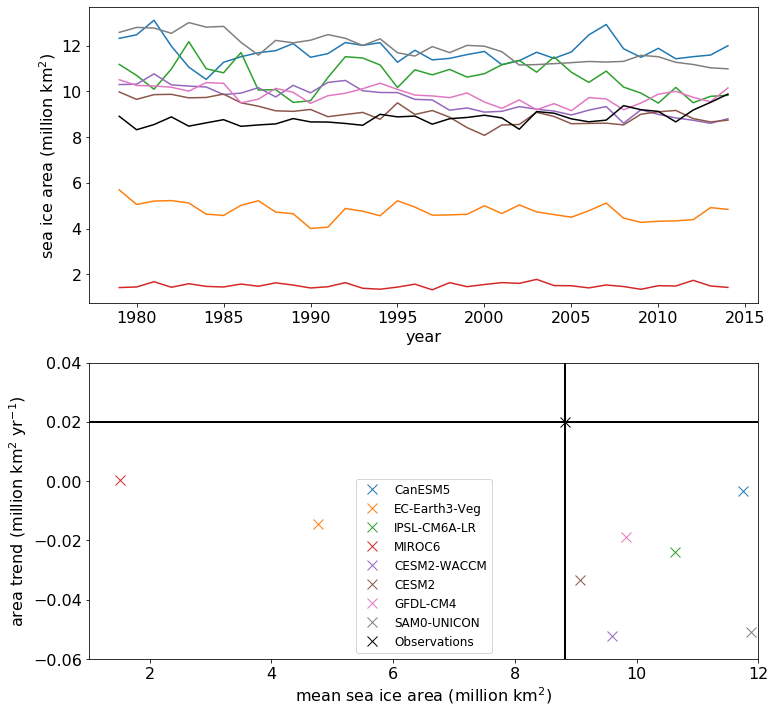

In [30]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = 12, 12

def get_trend(siarea):
    """
    Function to compute the linear trend in sea ice area
    """
    time = np.arange(1979, 2015)
    
    p = np.polyfit(time, siarea, 1)
    trend = p[0]
    
    return trend

# Keys for the sea ice area and cell area dataset dictionaries
sikeys = list(ds_dict.keys())
okeys = list(ds_dict2.keys())
sikeys.sort()
okeys.sort()

# List to contain model names for legend
modlist = list()

# Define time vectors
time = np.linspace(1980, 2006, 312)
tANN = np.arange(1979, 2015)

fig, (ax1, ax2) = plt.subplots(2, 1)

# Loop over the models and compute sea ice area time-series and plot
for n in np.arange(len(sikeys)):
    print(sikeys[n])
    ds = ds_dict[sikeys[n]].squeeze()
    print(ds.time.shape[0])
    ds2 = ds_dict2[okeys[n]].squeeze()
    siconc = ds['siconc']
    siconc = ds['siconc'][-432:, :int(ds[siconc.dims[1]].shape[0]/2), :]
    
    if 'member_id' not in ds2.dims:
        areacell = ds2['areacello'][:int(ds[siconc.dims[1]].shape[0]/2), :]
    else:
        areacell = ds2['areacello'][0, :int(ds[siconc.dims[1]].shape[0]/2), :].squeeze()
    
    siarea = siconc*areacell.data/1e14
    siarea_tseries = np.sum(siarea, axis=(1, 2))
    siarea_ANN = np.mean(np.reshape(np.array(siarea_tseries.data), (12, 36), order='F'), axis=0)
    
    ax1.plot(tANN, siarea_ANN)
    
    modlist.append(sikeys[n].split('.')[2])
    
    # Compute trend and magnitude for each model
    trend = get_trend(siarea_ANN)
    simag = np.mean(siarea_ANN)
    
    ax2.plot(simag, trend, 'x', markersize=10)
    
# Load observations
import pickle as pkl
with open('../../SHarea.pkl', 'rb') as f:
    yrs, areaANN = pkl.load(f)
    
# Cut off the last few years
yrs = yrs[:-4]
areaANN = areaANN[:-4]

# Compute the trend and magnitude for the observations
trendobs = get_trend(areaANN)
magobs = np.mean(areaANN)

ax1.plot(yrs, areaANN, 'k')
ax2.plot(magobs, trendobs, 'kx', markersize=10)
ax2.plot([magobs, magobs], [-0.07, 0.04], 'k', linewidth=2)
ax2.plot([0, 13], [trendobs, trendobs], 'k', linewidth=2)

modlist.append('Observations')
plt.ylim(-0.06, 0.04)
plt.xlim(1, 12)
plt.legend(modlist, fontsize=12)
ax1.set_ylabel('sea ice area (million km$^2$)')
ax1.set_xlabel('year')
ax2.set_ylabel('area trend (million km$^2$ yr$^{-1}$)')
ax2.set_xlabel('mean sea ice area (million km$^2$)')

In [31]:
fig.savefig('seaiceplot.png', bbox_inches='tight') # Save the figure